In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

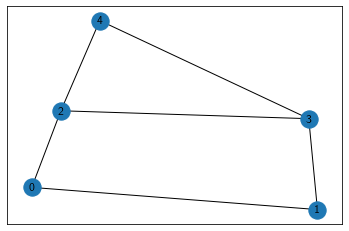

In [2]:
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,2.0),(2,3,1.5),(3,1,1.1),(3,4,0.4),(4,2,1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)

In [3]:
from qaoa import *

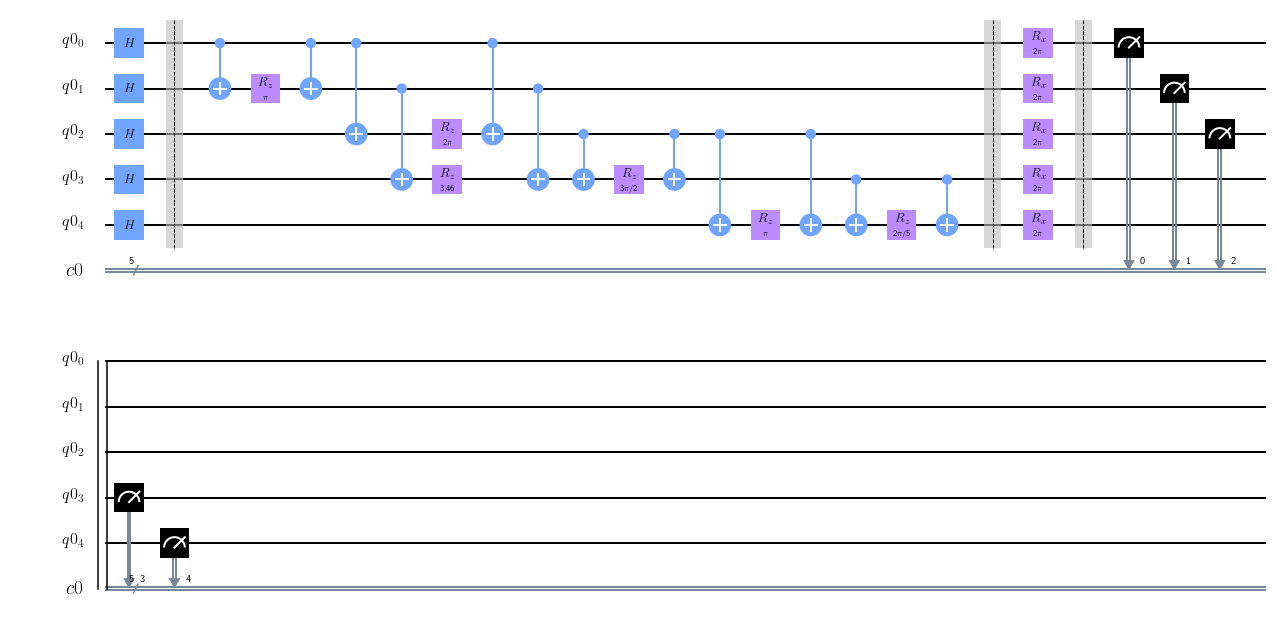

In [4]:
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,1,1,True).draw(output='mpl')

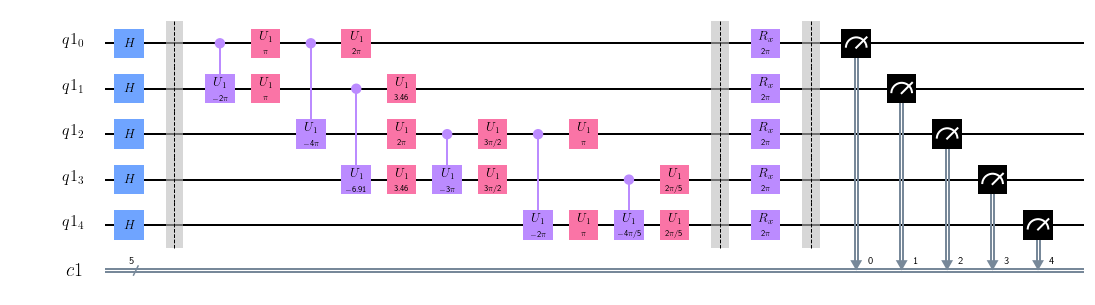

In [5]:
createCircuit_MaxCut(np.array((np.pi,np.pi)),G,1,2,True).draw(output='mpl')

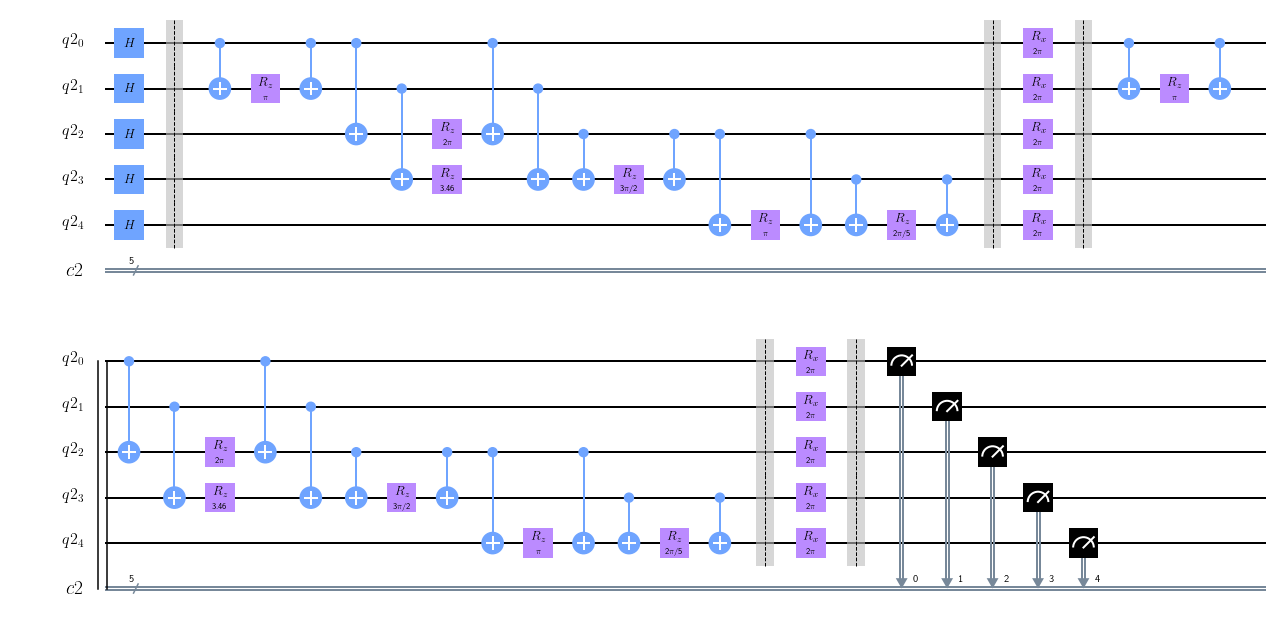

In [6]:
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,2,1,True).draw(output='mpl')

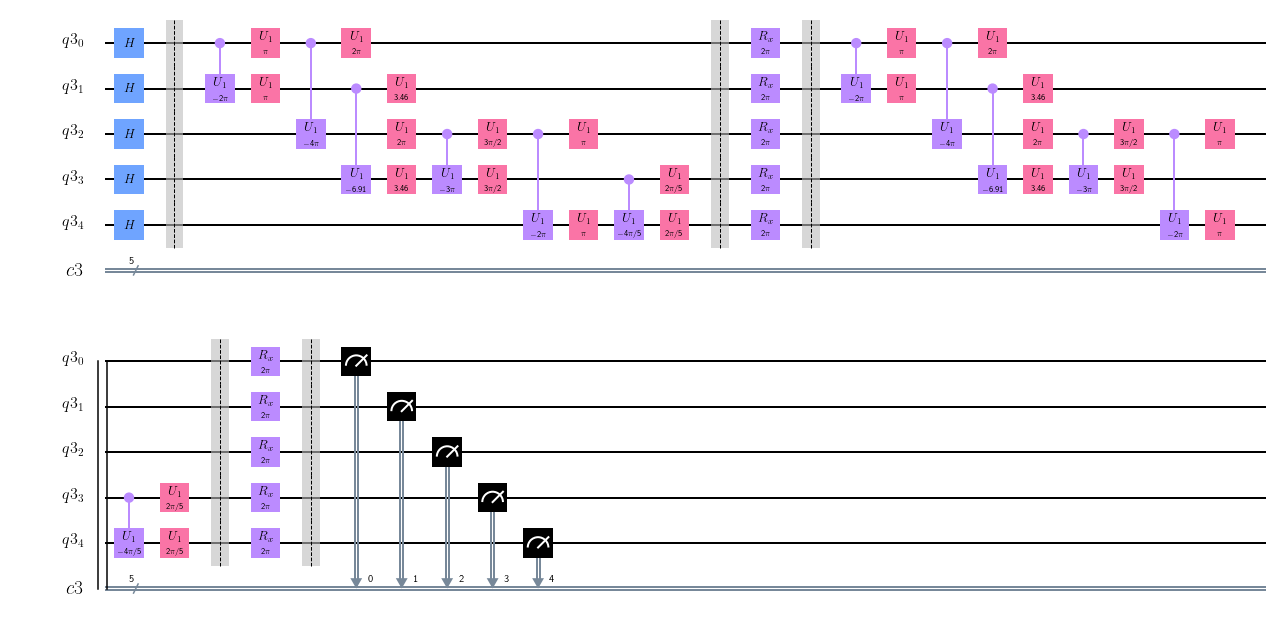

In [7]:
createCircuit_MaxCut(np.array((np.pi,np.pi,np.pi,np.pi)),G,2,2,True).draw(output='mpl')

In [8]:
costs=listSortedCosts_MaxCut(G)
costs

{'00000': 0.0,
 '11111': 0.0,
 '00001': 1.4,
 '11110': 1.4,
 '01000': 2.1,
 '10111': 2.1,
 '01010': 2.9,
 '10101': 2.9,
 '00010': 3.0,
 '01111': 3.0,
 '10000': 3.0,
 '11101': 3.0,
 '00111': 3.1,
 '11000': 3.1,
 '01001': 3.5,
 '01011': 3.5,
 '10100': 3.5,
 '10110': 3.5,
 '00011': 3.6,
 '11100': 3.6,
 '00101': 3.9,
 '11010': 3.9,
 '01110': 4.4,
 '10001': 4.4,
 '00100': 4.5,
 '00110': 4.5,
 '11001': 4.5,
 '11011': 4.5,
 '01101': 6.0,
 '10010': 6.0,
 '01100': 6.6,
 '10011': 6.6}

In [9]:
best_solutions={}
for key in costs:
    if costs[key]>=3.9:
        best_solutions[key] = costs[key]

In [10]:
ideal_solutions={}
for key in costs:
    if costs[key]>=6.5:
        ideal_solutions[key] = 100

In [11]:
def expectationValue(data,G):
    E=[]
    V = list(G.nodes)
    num_qubits = len(V)
    for item in range(0,len(data.results)):
        shots = data.results[item].shots
        counts = data.results[item].data.counts
        E.append(0)
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            binstring="{0:b}".format(int(key,0)).zfill(num_qubits)
            y=[int(i) for i in binstring]
            E[item] += cost_MaxCut(y,G)*c/shots
    return E

In [12]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')

In [13]:
circuits=[]
n=32
for beta in np.linspace(-np.pi/2,np.pi,n):
    for gamma in np.linspace(-np.pi/2,np.pi,n):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,1))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v1 = -np.array(expectationValue(job_sim.result(),G))

In [14]:
circuits=[]
n=32
for beta in np.linspace(-np.pi/2,np.pi,n):
    for gamma in np.linspace(-np.pi/2,np.pi,n):
        circuits.append(createCircuit_MaxCut(np.array((gamma,beta)),G,1,2))
job_sim = execute(circuits, backend_sim, shots=1024*2*2*2)
Elandscape_v2 = -np.array(expectationValue(job_sim.result(),G))

In [15]:
from scipy import optimize as opt

In [16]:
def getval(x, backend, depth=1, version=1, noisemodel=None):
    j = execute(createCircuit_MaxCut(x,G,depth,version), backend, noise_model=noisemodel, shots=1024*2*2*2)
    val=expectationValue(j.result(),G)
    global it, values, gamma, beta
    #print(x)
    it+=1
    gamma[str(it)] = x[0]
    beta[str(it)] = x[1]
    values[str(it)] = val
    return -val[0]

Optimization terminated successfully.
         Current function value: -4.338806
         Iterations: 11
         Function evaluations: 25
Optimal value= [0.57039062 1.2296875 ]


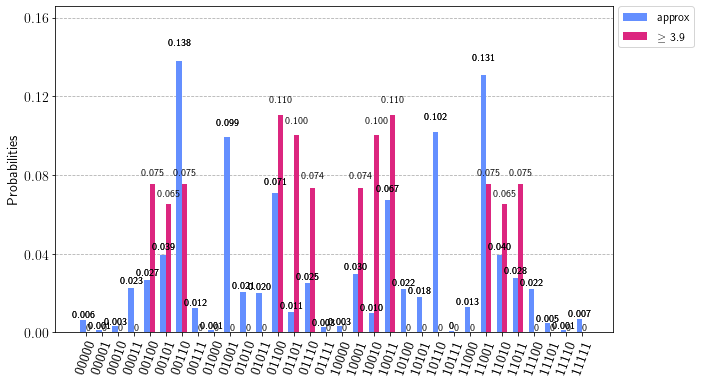

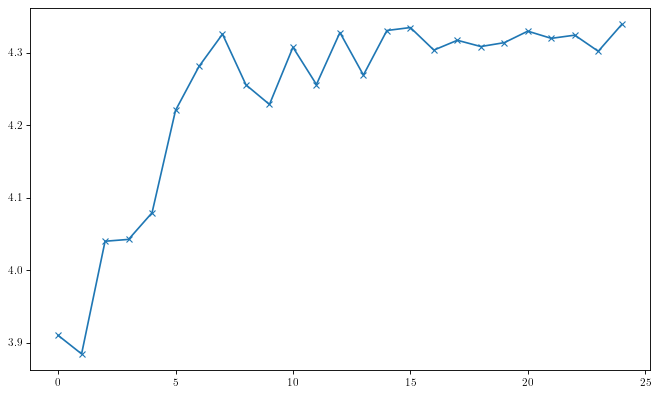

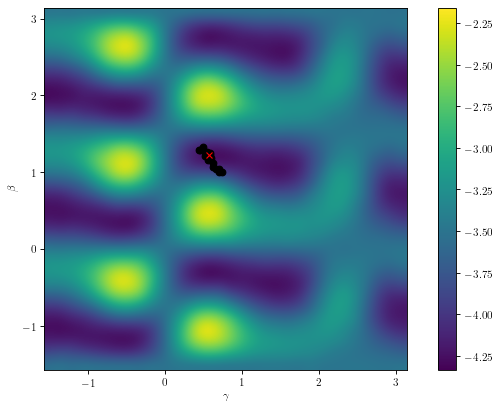

In [17]:
version=1
it=0
gamma={}
beta={}
values={}
out=opt.minimize(getval, x0=(.7,1), method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})
print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v1).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')

jv1 = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)

plot_histogram([jv1.result().get_counts(),best_solutions], figsize=(10, 6), legend=['approx',r'$\geq$ 3.9'])

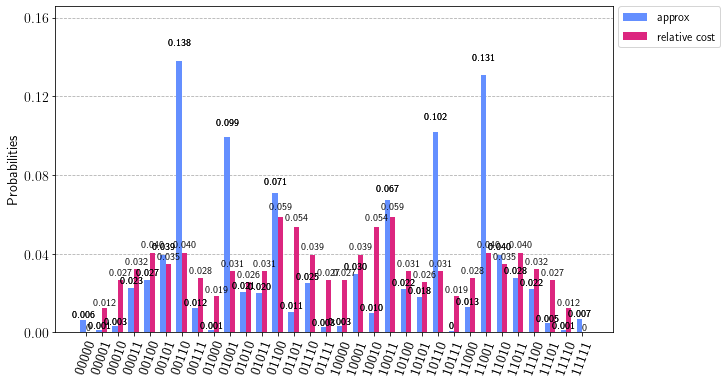

In [18]:
plot_histogram([jv1.result().get_counts(),costs], figsize=(10, 6), legend=['approx','relative cost'])

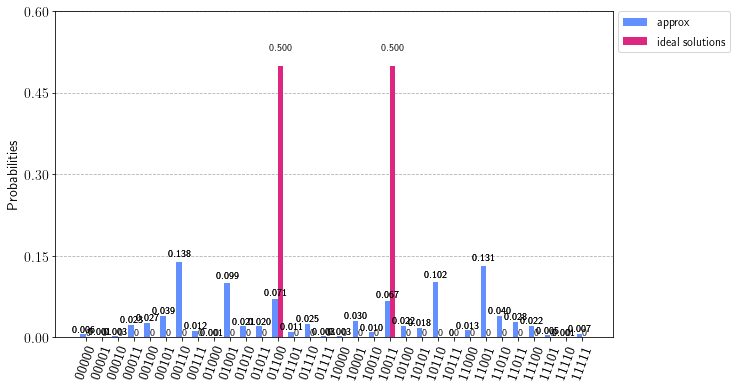

In [19]:
plot_histogram([jv1.result().get_counts(),ideal_solutions], figsize=(10, 6), legend=['approx','ideal solutions'])

Optimization terminated successfully.
         Current function value: -4.328186
         Iterations: 13
         Function evaluations: 28
Optimal value= [0.63875 1.225  ]


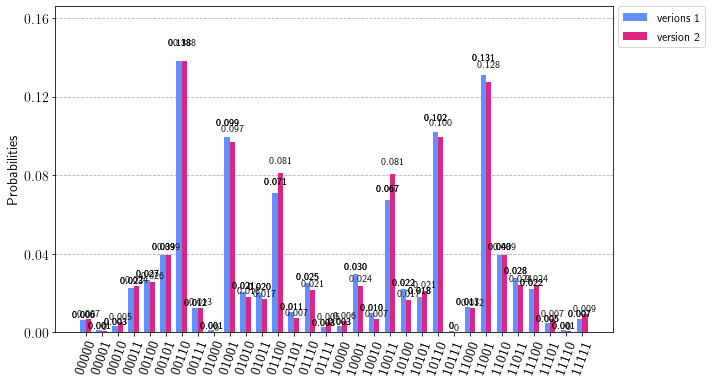

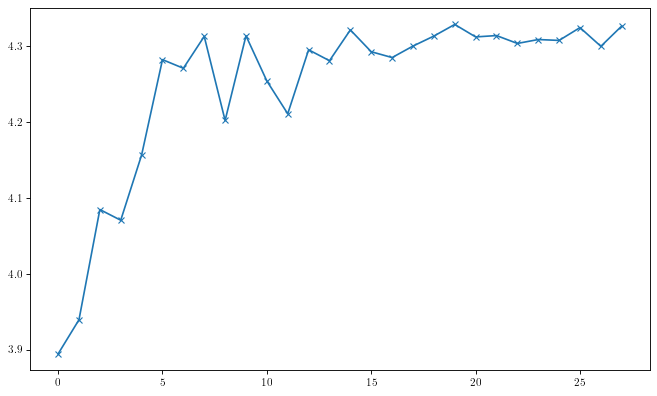

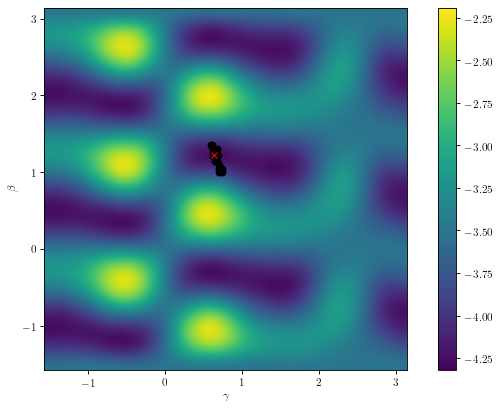

In [21]:
version=2
it=0
gamma={}
beta={}
values={}
out=opt.minimize(getval, x0=(.7,1), method='Nelder-Mead',\
                 args=(backend_sim,1,version,None),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

print("Optimal value=",out.x)
f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.plot(list(values.values()),'x-')

f = pl.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k');
pl.imshow(np.array(Elandscape_v2).reshape(n,n),interpolation='bicubic',origin='lower',extent=[-np.pi/2,np.pi,-np.pi/2,np.pi])
pl.colorbar()
pl.xlabel(r'$\gamma$')
pl.ylabel(r'$\beta$')
pl.plot(list(gamma.values()),list(beta.values()),'ko-')
pl.plot(out.x[0],out.x[1],'xr')

jv2 = execute(createCircuit_MaxCut(out.x,G,1,version), backend_sim, shots=1024*2*2*2)

plot_histogram([jv1.result().get_counts(),jv2.result().get_counts()], figsize=(10, 6), legend=['verions 1','version 2'])